## 6. Mom Divergence

## Divergence Index(Divergence)
长期动能上涨，短期动能下跌。
$$\text{Divergence Index} = \frac{10_{day} momentum *40_{day}momentum}{(40_{day}\text{ standard
 deviation of price changes)}^2}$$
Enter when Divergence Index falls below –10 and mom40>0

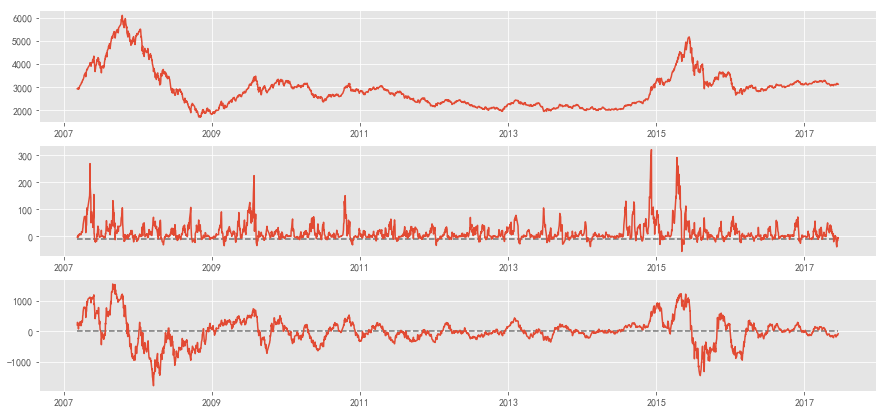

In [9]:
import talib as ta
from fxdayu_data import DataAPI
import matplotlib.pyplot as plt

DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')
hs300 = DataAPI.candle('sh000001', 'D')

hs300['mom10'] = ta.abstract.MOM(hs300, 10, price='close')
hs300['mom40'] = ta.abstract.MOM(hs300, 40, price='close')
hs300['price_change'] = hs300.close.diff()
hs300['Var40'] = ta.abstract.VAR(hs300, 40, price='price_change')
hs300 = hs300.dropna()
Div_index = hs300.mom10*hs300.mom40/hs300.Var40

fig = plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
plt.plot(hs300.close)
plt.subplot(3,1,2)
plt.plot(Div_index)
plt.hlines(-10, hs300.index[0], hs300.index[-1], linestyles='dashed', alpha=0.5)
plt.subplot(3,1,3)
plt.plot(hs300.mom40)
plt.hlines(0, hs300.index[0], hs300.index[-1], linestyles='dashed', alpha=0.5)
plt.show()

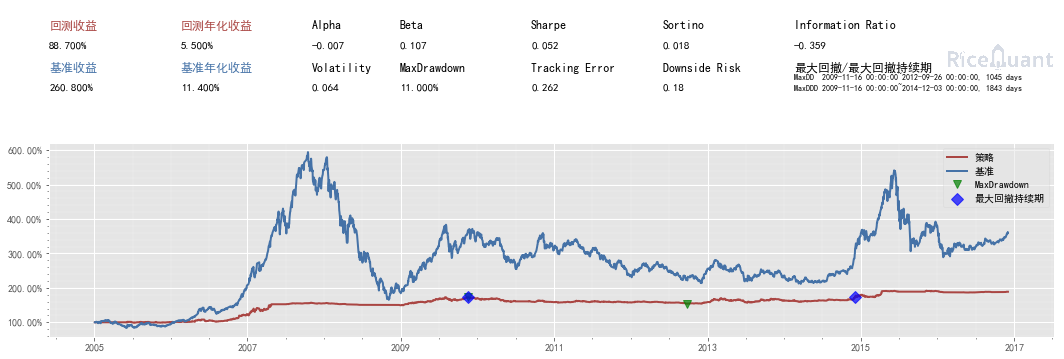

{'sys_analyser': {'benchmark_portfolio':               cash  market_value  static_unit_net_value  total_value  \
  date                                                                   
  2005-01-04  738.21      99261.79                  1.000    100000.00   
  2005-01-05  738.21     100248.56                  1.000    100986.77   
  2005-01-06  738.21      99300.17                  1.010    100038.38   
  2005-01-07  738.21      99379.96                  1.000    100118.17   
  2005-01-10  738.21     100381.88                  1.001    101120.09   
  2005-01-11  738.21     100711.14                  1.011    101449.35   
  2005-01-12  738.21     100671.75                  1.014    101409.96   
  2005-01-13  738.21     100684.88                  1.014    101423.09   
  2005-01-14  738.21      99819.31                  1.014    100557.52   
  2005-01-17  738.21      97712.45                  1.006     98450.66   
  2005-01-18  738.21      98443.69                  0.985     99181.90   

In [10]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """
import rqalpha
from rqalpha.api import *
import talib as ta
import os
import numpy as np
import pandas as pd

def init(context):
    update_universe('000001.XSHE')
    context.s1 = "000001.XSHE"
    context.LongPeriod = 50
    context.stoplossmultipler= 0.90 #止损 乘数
    context.takepofitmultipler= 4 #止盈 乘数

def handle_bar(context, bar_dict):
    entry_exit(context, bar_dict)

def entry_exit(context, bar_dict):
    stop_loss(context, bar_dict)
    prices = history_bars(context.s1, context.LongPeriod+2, '1d', 'close')
    if len(prices)>=context.LongPeriod+2:
        mom10 = ta.MOM(prices, 10)
        mom40 = ta.MOM(prices, 40)
        P_C = np.diff(prices)
        Var = ta.VAR(P_C, 40)
        Div_index = mom10[-1]*mom40[-1]/Var[-1]
        # print 'mom10:',mom10
        # print 'mom40:',mom40
        # print 'Price_Change:', P_C
        # print 'Var:', Var


        cur_position = context.portfolio.positions[context.s1].quantity
        shares = context.portfolio.cash/bar_dict[context.s1].close
        EMA_S = ta.EMA(prices, 15)
        EMA_L = ta.EMA(prices, context.LongPeriod)

        # if EMA_S[-1] < EMA_L[-1] and EMA_S[-2] > EMA_L[-2]:
        #     order_target_value(context.s1, 0)

        if Div_index < -1 and mom40[-1]>0 and cur_position == 0:
            order_target_value(context.s1, shares)

def stop_loss(context,bar_dict):
    for stock in context.portfolio.positions:
        if bar_dict[stock].last<context.portfolio.positions[stock].avg_price*context.stoplossmultipler:# 现价低于 原价一定比例
            order_target_percent(stock,0)
        elif bar_dict[stock].last>context.portfolio.positions[stock].avg_price*context.takepofitmultipler:# 现价高于原价一定比例
            order_target_percent(stock,0)
"""
config = {
  "base": {
    "start_date": "2000-06-01",
    "end_date": "2016-12-01",
    "securities": ['stock'],
    "stock_starting_cash": 100000,
    "benchmark": "000300.XSHG",
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
#       "report_save_path": '.',
      "enabled": True,
      "plot": True
    }
  }
}

run_code(code, config)